In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import joblib
import pickle

In [3]:
df_saham = pd.read_csv("../dataset/saham_data_cleaned_1h.csv")
df_saham["Datetime"] = pd.to_datetime(df_saham["Datetime"])
df_saham.set_index("Datetime", inplace=True)

In [4]:
# --- Cek & Bersihkan Data ---
df_saham.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")
df_saham.dropna(inplace=True)

# --- Fitur yang Digunakan ---
selected_features = ["Open", "High", "Low", "Close", "Volume", "Return"]

# --- Normalisasi Per Perusahaan ---
scaler_dict = {}
data_all = []

for ticker in df_saham['Ticker'].unique():
    df_ticker = df_saham[df_saham['Ticker'] == ticker].copy()
    df_ticker.dropna(inplace=True)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_ticker[selected_features])

    scaler_dict[ticker] = scaler

    df_scaled = pd.DataFrame(scaled, columns=selected_features)
    df_scaled["Ticker"] = ticker
    data_all.append(df_scaled)

# --- Gabungkan Semua Data Saham yang Sudah Dinormalisasi ---
df_scaled_all = pd.concat(data_all, ignore_index=True)

# --- One-hot encode kolom Ticker ---
df_scaled_all = pd.get_dummies(df_scaled_all, columns=["Ticker"])

# --- Bentuk Data Time Series ---
lookback = 30
X, y = [], []

data_scaled = df_scaled_all.values  # convert ke array

for i in range(lookback, len(data_scaled)):
    X.append(data_scaled[i - lookback:i])
    y.append(data_scaled[i])

# --- Split Data ---
X = np.array(X).astype(np.float64)
y = np.array(y).astype(np.float64)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

# --- Hitung Jumlah Fitur Output ---
num_output_features = y_train.shape[1]
print(f"Jumlah fitur output: {num_output_features}")

Shape X_train: (15617, 30, 12)
Shape X_test: (3905, 30, 12)
Jumlah fitur output: 12


In [ ]:
# Bangun model LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, kernel_regularizer='l2'),
    Dense(num_output_features)  
])


c:\Users\ejaad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

# Tampilkan ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,387 (134.32 KB)

 Trainable params: 34,387 (134.32 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:

# Training model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))



Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 46s 124ms/step - loss: 0.2435 - val_loss: 0.1064
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step - loss: 0.0173 - val_loss: 0.1051
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 53s 155ms/step - loss: 0.0066 - val_loss: 0.1009
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 60s 225ms/step - loss: 0.0054 - val_loss: 0.0978
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 51s 98ms/step - loss: 0.0053 - val_loss: 0.1079
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - loss: 0.0048 - val_loss: 0.1002
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - loss: 0.0048 - val_loss: 0.0989
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - loss: 0.0045 - val_loss: 0.1160
Epoch 9/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - loss: 0.0044 - val_loss: 0.1212
Epoch 10/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - loss: 0.0043 - val_loss: 0.1195
Epoch 11/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - loss: 0.0044 - val_loss: 0.1218
Epoch 12/50
245/245 ━━━━━━

In [8]:
# Prediksi pada data test
y_pred = model.predict(X_test)



123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluasi model (pada data yang dinormalisasi)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Tambahkan epsilon untuk menghindari pembagian dengan nol
epsilon = 1e-10
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Evaluation:")
print(f"🔸 Mean Squared Error (MSE): {mse:.6f}")
print(f"🔸 Mean Absolute Error (MAE): {mae:.6f}")
print(f"🔸 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"🔸 R² Score: {r2:.4f}")
print(f"✅ Model Accuracy (based on MAPE): {100 - mape:.2f}%")




📊 Model Evaluation:
🔸 Mean Squared Error (MSE): 0.138740
🔸 Mean Absolute Error (MAE): 0.166630
🔸 Mean Absolute Percentage Error (MAPE): 81366172981.18%
🔸 R² Score: -0.3837
✅ Model Accuracy (based on MAPE): -81366172881.18%


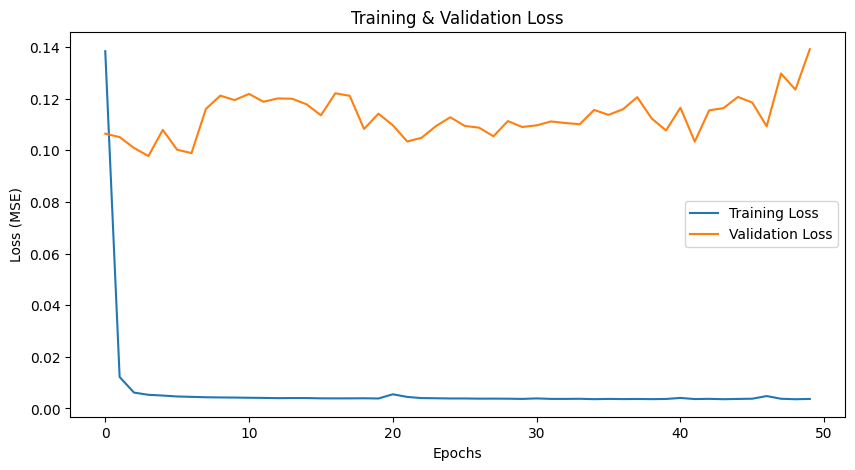

In [10]:
# Plot loss function
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


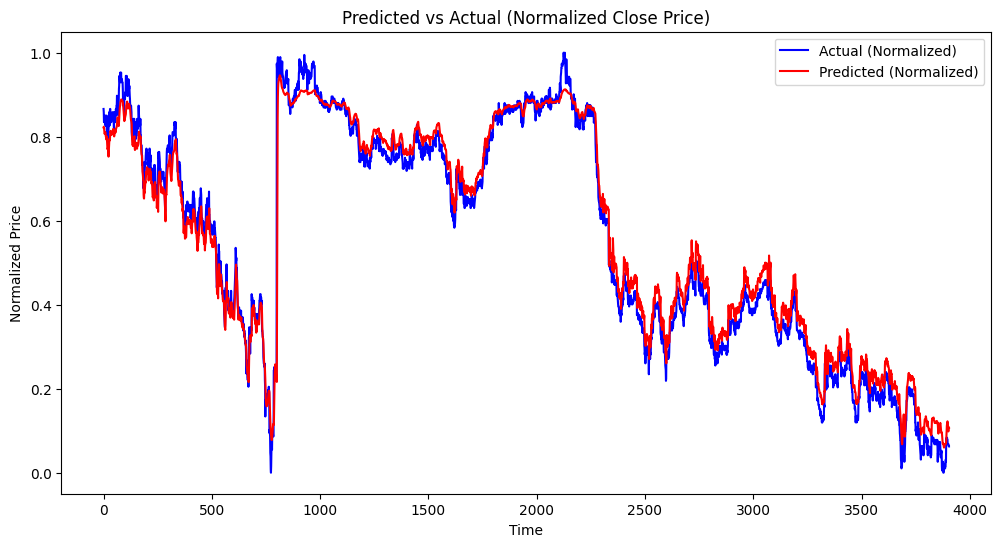

In [11]:
import matplotlib.pyplot as plt

# Asumsikan kolom 'Close' adalah kolom ke-3 sebelum one-hot encoding
close_index_normalized = selected_features.index("Close")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:, close_index_normalized], label="Actual (Normalized)", color='blue')
plt.plot(y_pred[:, close_index_normalized], label="Predicted (Normalized)", color='red')
plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.legend()
plt.title("Predicted vs Actual (Normalized Close Price)")
plt.show()


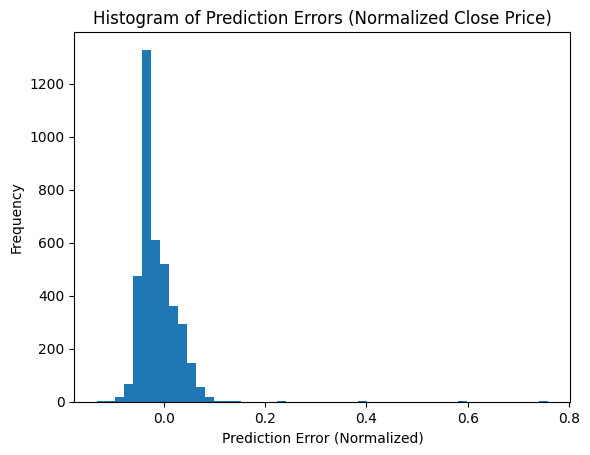

In [12]:

error_normalized = y_test[:, close_index_normalized] - y_pred[:, close_index_normalized]
plt.hist(error_normalized, bins=50)
plt.xlabel("Prediction Error (Normalized)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Normalized Close Price)")
plt.show()

In [13]:

# Simpan model ke .h5 (karena Keras tidak bisa dipickle langsung)
model.save("model_saham.h5")


In [14]:
# --- Simpan scaler per ticker ---
with open("scaler_ticker_saham.pkl", "wb") as f:
    pickle.dump(scaler_dict, f)


In [15]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import os

# --- Load data saham ---
df = pd.read_csv("../dataset/saham_data_cleaned_1h.csv")

# --- Bersihkan data ---
df.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")
df.dropna(inplace=True)

# --- Fitur utama dan perusahaan terakhir ---
selected_features = ["Open", "High", "Low", "Close", "Volume", "Return"]
last_ticker = df["Ticker"].iloc[-1]  # ticker terakhir
print("Last ticker:", last_ticker)

# Load scaler_dict yang berisi scaler per ticker
with open("scaler_ticker_saham.pkl", "rb") as f:
    scaler_dict = pickle.load(f)


# --- Ambil data dari ticker terakhir ---
df_last = df[df["Ticker"] == last_ticker].copy()
df_last = df_last[selected_features].dropna()

# --- Normalisasi menggunakan scaler sesuai ticker ---
scaler = scaler_dict[last_ticker]
scaled_data = scaler.transform(df_last[selected_features])

# --- One-hot encode ticker ---
tickers = df["Ticker"].unique()
one_hot = np.zeros((scaled_data.shape[0], len(tickers)))
ticker_index = np.where(tickers == last_ticker)[0][0]
one_hot[:, ticker_index] = 1

# --- Gabungkan data harga & one-hot menjadi 12 fitur ---
final_data = np.hstack([scaled_data, one_hot])

# --- Ambil last sequence sepanjang 30 langkah waktu ---
last_sequence = final_data[-30:]  # shape: (30, 12)

# --- Simpan scaler_dict dan last_sequence ---
with open("scaler_saham.pkl", "wb") as f:
    pickle.dump(scaler_dict, f)

np.save("last_sequence_saham.npy", last_sequence)

print("✅ last_sequence shape:", last_sequence.shape)  # Harus (30, 12)


Last ticker: TLKM.JK
✅ last_sequence shape: (30, 12)
